# Modelo preditivo usando TensorFlow

### Referências

https://www.tensorflow.org/tutorials/audio/simple_audio#run_inference_on_an_audio_file

https://stackoverflow.com/questions/46508055/using-ffmpeg-to-cut-audio-from-to-position

https://superuser.com/questions/650291/how-to-get-video-duration-in-seconds

https://stats.stackexchange.com/questions/231061/how-to-use-early-stopping-properly-for-training-deep-neural-network

https://towardsdatascience.com/how-to-easily-process-audio-on-your-gpu-with-tensorflow-2d9d91360f06

https://towardsdatascience.com/how-to-build-efficient-audio-data-pipelines-with-tensorflow-2-0-b3133474c3c1

https://github.com/bapalto/birdsong-keras/

https://matplotlib.org/stable/api/mlab_api.html#matplotlib.mlab.specgram

In [1]:
import os
import pathlib

import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers.experimental import preprocessing

import librosa
import librosa.display

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Audio as display_audio

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [2]:
# diretório de entrada
DIR_ENTRADA = 'wavbal5f'

# duração de cada trecho de áudio
DURACAO_TRECHO = 5 # segundos

# taxa de amostragem (sampling rate)
SAMPLING_RATE = 16000 # 16 kHz

# total de pontos de onda no áudio
PONTOS_ONDA = SAMPLING_RATE * DURACAO_TRECHO # 16 kHz * 5 s = 80000

In [3]:
FFT_SIZE = 256 #1024 #255
HOP_SIZE = 128 #512 #128
N_MEL_BINS = 64
N_SPECTROGRAM_BINS = (FFT_SIZE // 2) #+ 1
F_MIN = 0.0
F_MAX = SAMPLING_RATE / 2
N_SPECTROGRAM_BINS

128

## Carregar arquivos de áudio

In [4]:
# define o diretório raiz dos arquivos de entrada

data_dir = pathlib.Path(DIR_ENTRADA)
data_dir

PosixPath('wavbal5f')

In [5]:
# calcula e extrai as possíveis classes

especies = np.array(tf.io.gfile.listdir(str(data_dir)))
#especies = especies[especies != 'README.md']
#especies2 = [x.replace('_', ' ') for x in especies.tolist()]
especies = np.sort(especies)

print('Espécies: %d\n\n%s' % (especies.shape[0], especies.tolist()))

Espécies: 74

['amazona_farinosa', 'aramides_cajaneus', 'attila_spadiceus', 'automolus_infuscatus', 'bucco_capensis', 'cacicus_cela', 'campephilus_rubricollis', 'cathartes_aura', 'celeus_undatus', 'ceratopipra_erythrocephala', 'chloroceryle_americana', 'coragyps_atratus', 'cyclarhis_gujanensis', 'dacnis_cayana', 'dacnis_lineata', 'dendrocincla_fuliginosa', 'dryocopus_lineatus', 'euphonia_violacea', 'formicarius_colma', 'geotrygon_montana', 'glyphorynchus_spirurus', 'hylocharis_cyanus', 'hylophilus_thoracicus', 'hypocnemis_cantator', 'isleria_guttata', 'lepidothrix_serena', 'leptotila_rufaxilla', 'leucopternis_melanops', 'lipaugus_vociferans', 'manacus_manacus', 'micrastur_semitorquatus', 'mionectes_macconnelli', 'myiarchus_ferox', 'myiopagis_gaimardii', 'myrmoderus_ferrugineus', 'myrmotherula_brachyura', 'myrmotherula_surinamensis', 'onychorhynchus_coronatus', 'patagioenas_plumbea', 'phaethornis_ruber', 'phaethornis_rupurumii', 'phaethornis_superciliosus', 'piaya_cayana', 'pionites_mel

In [6]:
# obtém os nomes dos arquivos de áudio disponíveis

filenames = tf.io.gfile.glob(str(data_dir) + '/*/*.wav')
#filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)

num_samples = len(filenames)
num_samples_per_class = len(tf.io.gfile.listdir(str(data_dir / especies[0])))

print('Número total de classes      : %5d' % especies.shape[0])
print('Número total de amostras     : %5d' % num_samples)
print('Número de amostras por classe: %5d' % num_samples_per_class) 
print('\nExemplo de arquivo de tensor:\n ', filenames[0])

Número total de classes      :    74
Número total de amostras     : 43734
Número de amostras por classe:   591

Exemplo de arquivo de tensor:
  tf.Tensor(b'wavbal5f/bucco_capensis/Bucco270621-00-001.wav', shape=(), dtype=string)


In [7]:
filenames

<tf.Tensor: shape=(43734,), dtype=string, numpy=
array([b'wavbal5f/bucco_capensis/Bucco270621-00-001.wav',
       b'wavbal5f/myrmotherula_surinamensis/Myrmotherula88437-01-002.wav',
       b'wavbal5f/leucopternis_melanops/Leucopternis508217-01-003.wav',
       ..., b'wavbal5f/turdus_albicollis/Turdus122600-00-010.wav',
       b'wavbal5f/myrmoderus_ferrugineus/Myrmoderus216501-00-001.wav',
       b'wavbal5f/cathartes_aura/Cathartes520288-03-009.wav'],
      dtype=object)>

In [8]:
# define as proporções dos dados entre treino, validação e teste

PCT_TRAINING = 0.8
PCT_VALIDATION = 0.1

train_rows = int(num_samples * PCT_TRAINING)
val_rows = int(num_samples * PCT_VALIDATION)
test_rows = num_samples - (train_rows + val_rows)

In [9]:
# divide os arquivos entre treino, validação e teste

train_files = filenames[:train_rows]
val_files = filenames[train_rows : train_rows + val_rows]
test_files = filenames[-test_rows:]

print('Tamanho do conjunto de treinamento: %6d' % len(train_files))
print('Tamanho do conjunto de validação  : %6d' % len(val_files))
print('Tamanho do conjunto de testes     : %6d' % len(test_files))

Tamanho do conjunto de treinamento:  34987
Tamanho do conjunto de validação  :   4373
Tamanho do conjunto de testes     :   4374


In [10]:
# decodifica o áudio em formato binário

def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

In [11]:
# extrai o nome da classe a partir do caminho completo do arquivo

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)

    # Note: You'll use indexing here instead of tuple
    # unpacking to enable this to work in a TensorFlow graph.
    return parts[-2]

In [12]:
# decodifica o áudio e extrai o nome da classe do arquivo

def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [13]:
# criar dados de ondas sonoras como TensorFlow Dataset

AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

print(waveform_ds)
#print(list(waveform_ds.take(3).as_numpy_iterator()))

<ParallelMapDataset shapes: ((None,), ()), types: (tf.float32, tf.string)>


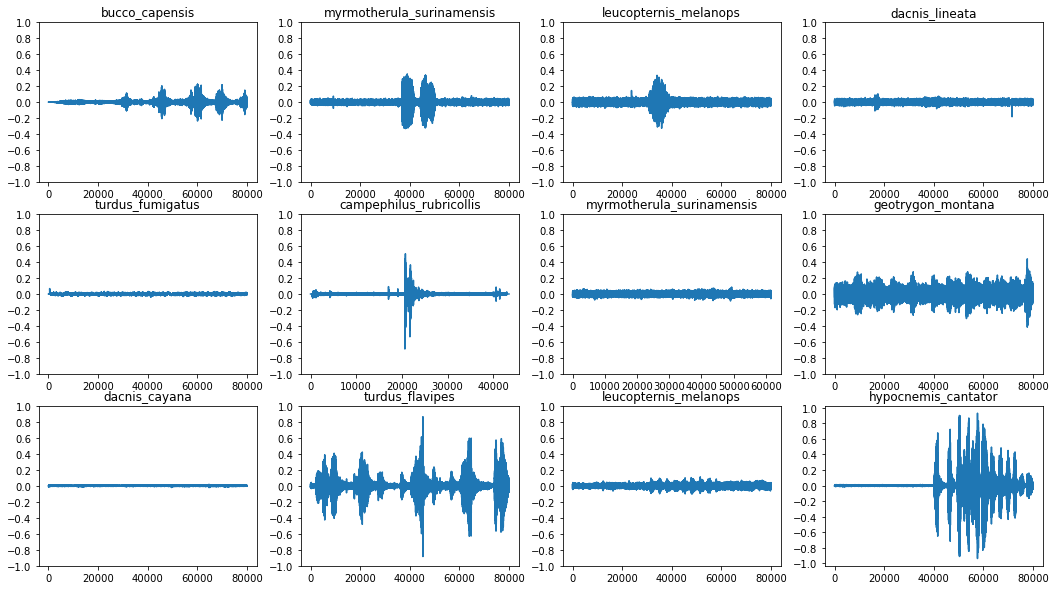

In [14]:
# plotar ondas sonoras de exemplo

rows = 3
cols = 4
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(18, 10))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.0, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()

In [15]:
# obtém o espectrograma a partir de um formato de onda

def get_spectrogram(waveform):
    #print("tf.shape:", tf.shape(waveform))

    # Padding for files with less than 16000 samples
    zero_padding = tf.zeros([PONTOS_ONDA] - tf.shape(waveform), dtype=tf.float32)

    # Concatenate audio with padding so that all audio clips will be of the same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    
    spectrogram = tf.signal.stft(equal_length, frame_length=FFT_SIZE, frame_step=HOP_SIZE)
    spectrogram = tf.abs(spectrogram)
    
    return spectrogram

In [16]:
# extrair áudio e informações de um arquivo de exemplo

for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')

#display.display(display.Audio(waveform, rate=16000))
display_audio(waveform, rate=SAMPLING_RATE)

Label: bucco_capensis
Waveform shape: (80000,)
Spectrogram shape: (624, 129)
Audio playback


In [17]:
# plota forma de onda

def plot_waveform(waveform, ax):
    timescale = np.arange(waveform.shape[0])
    ax.plot(timescale, waveform)
    ax.set_title('Waveform')
    ax.set_xlim([0, PONTOS_ONDA])

In [18]:
# plota espectrograma

def plot_spectrogram(spectrogram, ax):
    # Convert to frequencies to log scale and transpose so that
    # the time is represented in the x-axis (columns)
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.set_title('Spectrogram')
    ax.pcolormesh(X, Y, log_spec, shading='auto')

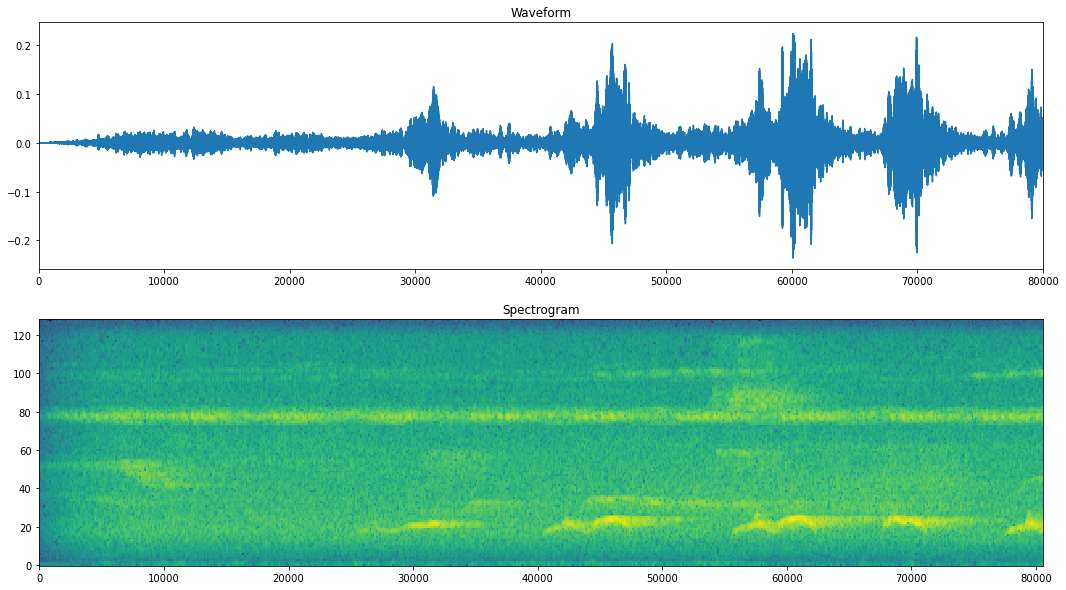

In [19]:
# plotar forma de onda e espectrograma do arquivo de exemplo

fig, axes = plt.subplots(2, figsize=(18, 10))

plot_waveform(waveform.numpy(), axes[0])
plot_spectrogram(spectrogram.numpy(), axes[1])

plt.savefig('images/wavespec.png', dpi=300)
plt.show()

In [20]:
# plota espectro de magnitude

def plot_magnitude_spectrogram(spectrogram, fig, ax):
    S = spectrogram.T
    ax.set_title('Magnitude spectrogram')
    img = librosa.display.specshow(S,
                                   sr=SAMPLING_RATE,
                                   y_axis='linear',
                                   ax=ax)
    fig.colorbar(img, ax=ax)

In [21]:
# plota espectro de magnitude logarítimica

def plot_logmagnitude_spectrogram(spectrogram, fig, ax):
    S = spectrogram.T
    ax.set_title('Log-magnitude spectrogram')
    img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                                   y_axis='linear',
                                   x_axis='time',
                                   sr=SAMPLING_RATE,
                                   hop_length=HOP_SIZE,
                                   ax=ax)
    fig.colorbar(img, ax=ax, format="%+2.f dB")

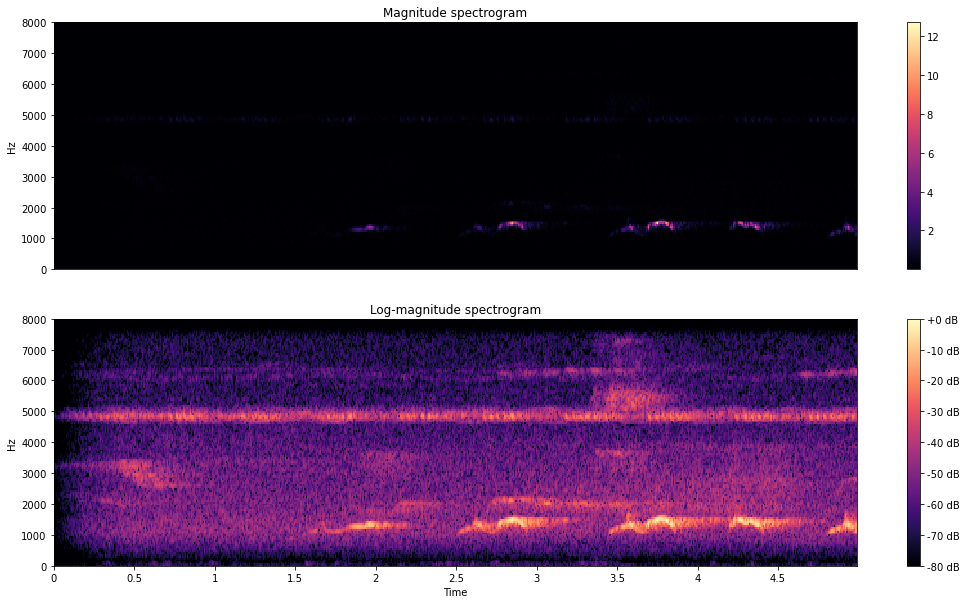

In [22]:
# plotar espectros de magnitude e magnitude logarítimica do arquivo de exemplo

fig, axes = plt.subplots(2, figsize=(18, 10))

plot_magnitude_spectrogram(spectrogram.numpy(), fig, axes[0])
plot_logmagnitude_spectrogram(spectrogram.numpy(), fig, axes[1])

plt.savefig('images/magspec.png', dpi=300)
plt.show()

In [30]:
# criar banco de filtro em escala Mel

mel_filterbank = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=N_MEL_BINS,
    num_spectrogram_bins=N_SPECTROGRAM_BINS + 1, # verificar esse número aqui!
    sample_rate=SAMPLING_RATE,
    lower_edge_hertz=F_MIN,
    upper_edge_hertz=F_MAX
)

print('Mel-filterbank shape:', mel_filterbank.shape)

Mel-filterbank shape: (129, 64)


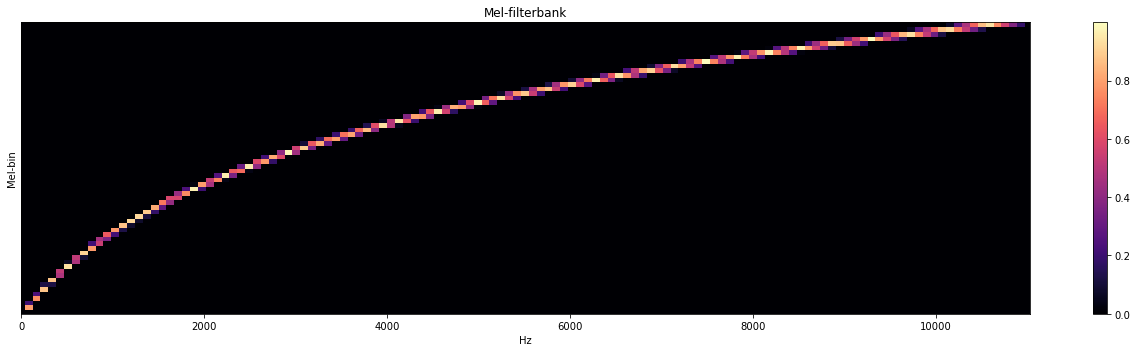

In [31]:
# plotar banco de filtro em escala Mel

plt.figure(figsize=(18, 5))

librosa.display.specshow(mel_filterbank.numpy().T, x_axis='linear')
plt.ylabel('Mel-bin')
plt.title('Mel-filterbank')
plt.colorbar()

plt.tight_layout()
plt.savefig('images/filterbank.png', dpi=300)
plt.show()

In [32]:
# converte um espectrograma de potência em unidades decibel (dB)

def power_to_db(S, amin=1e-16, top_db=80.0):
    """Convert a power-spectrogram (magnitude squared) to decibel (dB) units.

    Computes the scaling ``10 * log10(S / max(S))`` in a numerically
    stable way.

    Based on:
    https://librosa.org/doc/latest/generated/librosa.power_to_db.html
    """
    def _tf_log10(x):
        numerator = tf.math.log(x)
        denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
        return numerator / denominator
    
    # Scale magnitude relative to maximum value in S.
    # Zeros in the output correspond to positions where S == ref.
    ref = tf.reduce_max(S)

    log_spec = 10.0 * _tf_log10(tf.maximum(amin, S))
    log_spec -= 10.0 * _tf_log10(tf.maximum(amin, ref))

    log_spec = tf.maximum(log_spec, tf.reduce_max(log_spec) - top_db)

    return log_spec

In [33]:
# calcula o espectrograma em escala Mel a partir do espectrograma

def get_mel_spectrogram(spectrogram):
#def get_log_magnitude_mel_spectrogram(spectrogram):

    #print('Spectrogram shape:', spectrogram.shape)
    
    mel_power_spectrogram = tf.matmul(tf.square(spectrogram), mel_filterbank)
    #print('Mel-power spectrogram shape:', mel_power_spectrogram.shape)
    
    log_magnitude_mel_spectrogram = power_to_db(mel_power_spectrogram)
    #print('Log-magnitude mel-scaled spectrogram shape:', log_magnitude_mel_spectrogram.shape)
    
    return log_magnitude_mel_spectrogram

In [34]:
# plot o espectrograma em escala Mel

def plot_mel_spectrogram(mel_spectrogram, fig, ax):
    ax.set_title('Log-magnitude mel-scaled spectrogram')
    print("mel_spectrogram shape:", mel_spectrogram.shape)
#    img = librosa.display.specshow(mel_spectrogram.numpy().T,
    img = librosa.display.specshow(mel_spectrogram.T,
                                   y_axis='mel',
                                   x_axis='time',
                                   sr=SAMPLING_RATE,
                                   hop_length=HOP_SIZE)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')

mel_spectrogram shape: (624, 64)


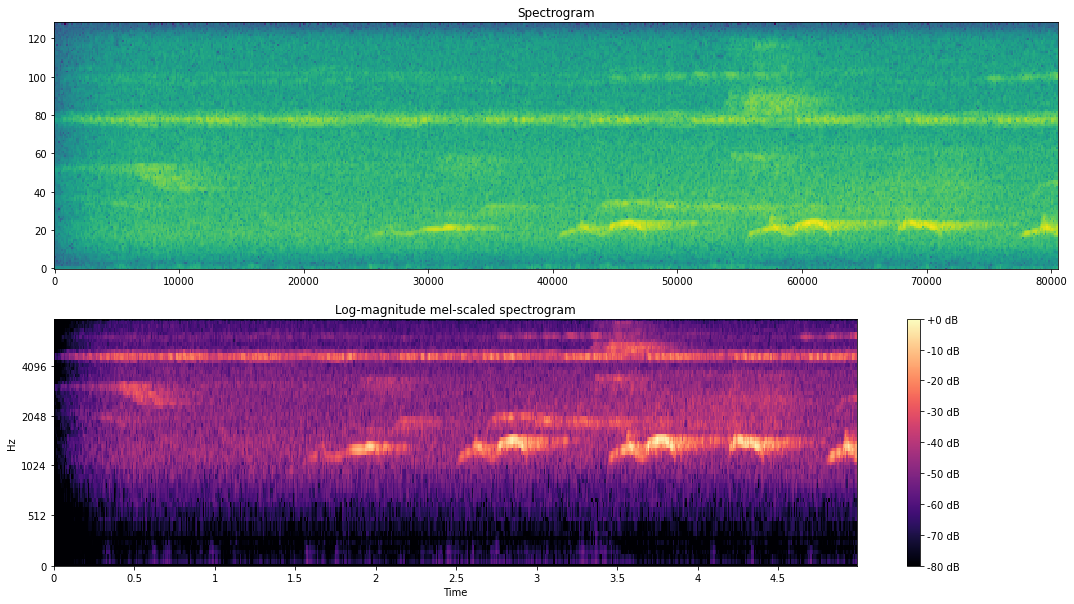

In [35]:
# plotar espectrograma convencional e espectrograma de magnitude logarítimica em escala Mel

mel_spectrogram = get_mel_spectrogram(spectrogram)

fig, axes = plt.subplots(2, figsize=(18, 10))

plot_spectrogram(spectrogram.numpy(), axes[0])
plot_mel_spectrogram(mel_spectrogram.numpy(), fig, axes[1])

plt.savefig('images/melspec.png', dpi=300)
plt.show()

In [36]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    print("spectrogram shape:", spectrogram.shape)
    spectrogram = tf.expand_dims(spectrogram, -1)
    print("spectrogram shape:", spectrogram.shape)
    label_id = tf.argmax(label == especies)
    return spectrogram, label_id

In [37]:
# criar dados de espectrograma como TensorFlow Dataset

spectrogram_ds = waveform_ds.map(get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

#print(list(spectrogram_ds.take(3).as_numpy_iterator()))
print(spectrogram_ds)

spectrogram shape: (None, 129)
spectrogram shape: (None, 129, 1)
<ParallelMapDataset shapes: ((None, 129, 1), ()), types: (tf.float32, tf.int64)>


In [38]:
def get_melspectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    print("spectrogram shape:", spectrogram.shape)
    #spectrogram = tf.expand_dims(spectrogram, -1)
    mel_spectrogram = get_mel_spectrogram(spectrogram)
    print("mel_spectrogram shape:", mel_spectrogram.shape)
    mel_spectrogram = tf.expand_dims(mel_spectrogram, -1)
    print("mel_spectrogram shape:", mel_spectrogram.shape)
    label_id = tf.argmax(label == especies)
    return mel_spectrogram, label_id

In [39]:
# criar dados de espectrograma Mel como TensorFlow Dataset

melspectrogram_ds = waveform_ds.map(get_melspectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

#print(list(melspectrogram_ds.take(3).as_numpy_iterator()))
print(melspectrogram_ds)

spectrogram shape: (None, 129)
mel_spectrogram shape: (None, 64)
mel_spectrogram shape: (None, 64, 1)
<ParallelMapDataset shapes: ((None, 64, 1), ()), types: (tf.float32, tf.int64)>


spectrogram shape: (624, 129, 1)
spectrogram shape: (624, 129, 1)
spectrogram shape: (624, 129, 1)
spectrogram shape: (624, 129, 1)
spectrogram shape: (624, 129, 1)
spectrogram shape: (624, 129, 1)
spectrogram shape: (624, 129, 1)
spectrogram shape: (624, 129, 1)
spectrogram shape: (624, 129, 1)


<ipython-input-18-3aa99f50ee89>:6: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


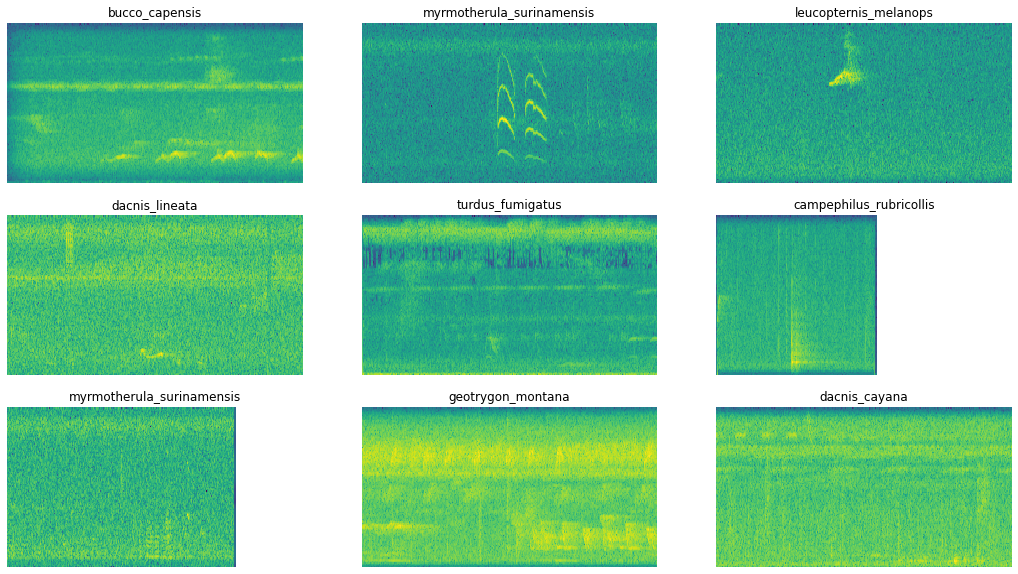

In [40]:
# plotar espectrogramas de exemplo

rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(18, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    #print(i, label_id, label_id.numpy(), especies[label_id.numpy()])
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    print("spectrogram shape:", spectrogram.shape)
    plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
    ax.set_title(especies[label_id.numpy()])
    ax.axis('off')

plt.show()

0 tf.Tensor(4, shape=(), dtype=int64) 4 bucco_capensis
mel_spectrogram shape: (624, 64, 1)
mel_spectrogram shape: (624, 64)
1 tf.Tensor(36, shape=(), dtype=int64) 36 myrmotherula_surinamensis
mel_spectrogram shape: (624, 64, 1)
mel_spectrogram shape: (624, 64)
2 tf.Tensor(27, shape=(), dtype=int64) 27 leucopternis_melanops
mel_spectrogram shape: (624, 64, 1)
mel_spectrogram shape: (624, 64)
3 tf.Tensor(14, shape=(), dtype=int64) 14 dacnis_lineata
mel_spectrogram shape: (624, 64, 1)
mel_spectrogram shape: (624, 64)
4 tf.Tensor(69, shape=(), dtype=int64) 69 turdus_fumigatus
mel_spectrogram shape: (624, 64, 1)
mel_spectrogram shape: (624, 64)
5 tf.Tensor(6, shape=(), dtype=int64) 6 campephilus_rubricollis
mel_spectrogram shape: (624, 64, 1)
mel_spectrogram shape: (624, 64)
6 tf.Tensor(36, shape=(), dtype=int64) 36 myrmotherula_surinamensis
mel_spectrogram shape: (624, 64, 1)
mel_spectrogram shape: (624, 64)
7 tf.Tensor(19, shape=(), dtype=int64) 19 geotrygon_montana
mel_spectrogram shape:

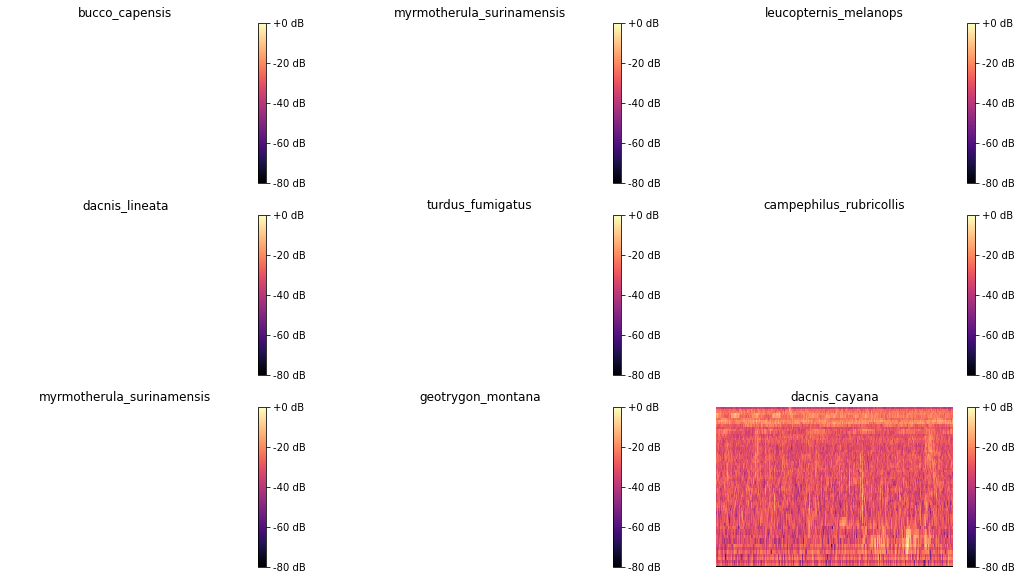

In [41]:
# plotar espectrogramas Mel de exemplo

rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(18, 10))

for i, (mel_spectrogram, label_id) in enumerate(melspectrogram_ds.take(n)):
    print(i, label_id, label_id.numpy(), especies[label_id.numpy()])
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    print("mel_spectrogram shape:", mel_spectrogram.shape)
    plot_mel_spectrogram(np.squeeze(mel_spectrogram.numpy()), fig, ax)
    ax.set_title(especies[label_id.numpy()])
    ax.axis('off')

plt.show()

In [42]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)
    #output_ds = output_ds.map(get_melspectrogram_and_label_id, num_parallel_calls=AUTOTUNE)
    return output_ds

In [43]:
# preparar conjuntos de dados de treino, validação e testes

#train_ds = spectrogram_ds
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

print("train_ds:\n\t", train_ds, "\n\t", train_ds.cardinality())
print("val_ds:\n\t", val_ds, "\n\t", val_ds.cardinality())
print("test_ds:\n\t", test_ds, "\n\t", test_ds.cardinality())

spectrogram shape: (None, 129)
spectrogram shape: (None, 129, 1)
spectrogram shape: (None, 129)
spectrogram shape: (None, 129, 1)
spectrogram shape: (None, 129)
spectrogram shape: (None, 129, 1)
train_ds:
	 <ParallelMapDataset shapes: ((None, 129, 1), ()), types: (tf.float32, tf.int64)> 
	 tf.Tensor(34987, shape=(), dtype=int64)
val_ds:
	 <ParallelMapDataset shapes: ((None, 129, 1), ()), types: (tf.float32, tf.int64)> 
	 tf.Tensor(4373, shape=(), dtype=int64)
test_ds:
	 <ParallelMapDataset shapes: ((None, 129, 1), ()), types: (tf.float32, tf.int64)> 
	 tf.Tensor(4374, shape=(), dtype=int64)


In [44]:
# definir o tamanho do lote dos dados de treino e validação

#BATCH_SIZE = 32
#BATCH_SIZE = 128 # muito lento!!!
BATCH_SIZE = 64

train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)

In [45]:
# colocar dados de treino e validação em memória (cache)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [46]:
# obter o formato da entrada a partir de um exemplo

for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
for mel_spectrogram, _ in melspectrogram_ds.take(1):
    input_shape = mel_spectrogram.shape

print('Input shape:', input_shape)
num_labels = len(especies)

Input shape: (624, 64, 1)


In [47]:
spectrogram.numpy().shape

(624, 129, 1)

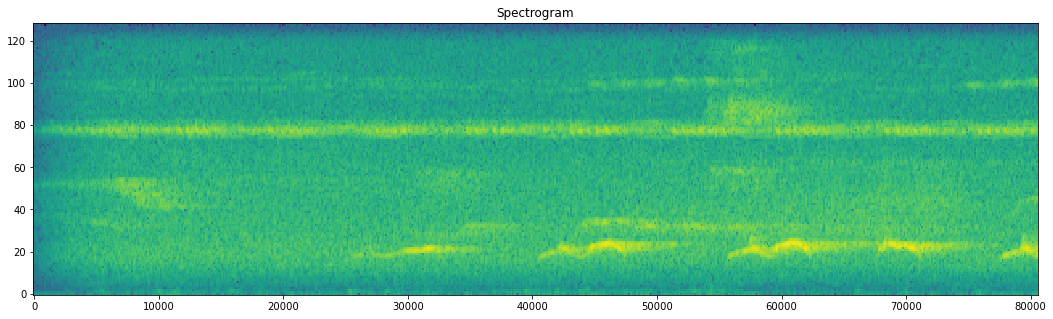

In [48]:
fig, ax = plt.subplots(1, figsize=(18, 5))
plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
plt.show()

In [49]:
mel_spectrogram = next(iter(melspectrogram_ds))[0]
mel_spectrogram.numpy().shape

(624, 64, 1)

mel_spectrogram shape: (624, 64)


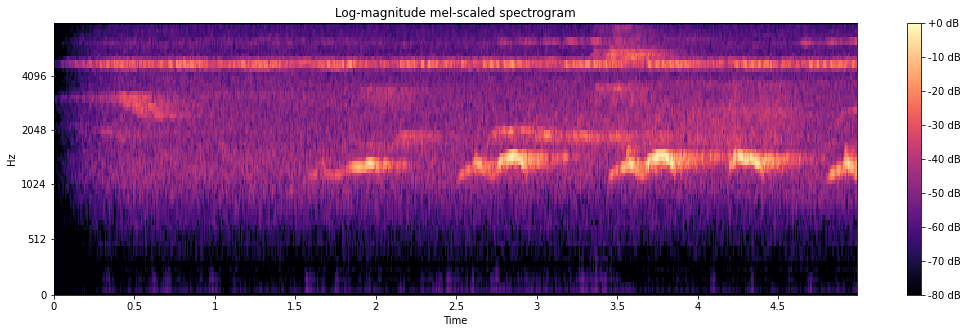

In [51]:
fig, ax = plt.subplots(1, figsize=(18, 5))
plot_mel_spectrogram(np.squeeze(mel_spectrogram.numpy()), fig, ax)
plt.show()

In [ ]:
%%time

norm_layer = preprocessing.Normalization()
norm_layer.adapt(melspectrogram_ds.map(lambda x, _: x, num_parallel_calls=AUTOTUNE))
#norm_layer.adapt(spectrogram_ds.map(lambda x, _: x, num_parallel_calls=AUTOTUNE))
#norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))
norm_layer

Cause: could not parse the source code of <function <lambda> at 0x7fcc3a4d1160>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fcc3a4d1160>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    #layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
%%time

EPOCHS = 150
PATIENCE = 15

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=PATIENCE)
)

In [ ]:
def plot_training_and_validation_loss_and_accuracy(history):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    metrics = history.history
    keys = list(metrics.keys())

    loss_values = metrics[keys[0]] # loss
    val_loss_values = metrics[keys[2]] # val_loss
    epochs = range(1, len(metrics[keys[0]]) + 1)

    ax1.plot(epochs, loss_values, 'bo', label='Training loss')
    ax1.plot(epochs, val_loss_values, 'b', label='Validation loss')
    ax1.set(title='Training and validation loss',
            xlabel='Epochs',
            ylabel='Loss')
    ax1.legend()

    acc_values = metrics[keys[1]] # accuracy
    val_acc_values = metrics[keys[3]] # val_accuracy

    ax2.plot(epochs, acc_values, 'bo', label='Training accuracy')
    ax2.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
    ax2.set(title='Training and validation accuracy',
            xlabel='Epochs',
            ylabel='Accuracy')
    ax2.legend()

    plt.show()

In [ ]:
# Plotting the training and validation loss and accuracy

plot_training_and_validation_loss_and_accuracy(history)

In [ ]:
# número ótimo de épocas obtido anteriormente
numero_otimo_epocas=31

In [ ]:
%%time

# treinar novamente o modelo, mas agora com todos
# os dados disponíveis (sem dados de validação) e
# pelo número ótimo de épocas obtido anteriormente
#numero_otimo_epocas=28

model.fit(
    train_ds,
    epochs=numero_otimo_epocas
)

In [ ]:
saved_model = 'modelos/modelo-especie-audio-tensorflow-%dep.h5' % (numero_otimo_epocas)
saved_model

In [ ]:
# salvar o modelo treinado em disco
model.save(saved_model)

In [ ]:
# carregar um modelo previamente treinado
from tensorflow.keras.models import load_model

model = load_model(saved_model)
model

## Avaliar precisão do modelo nos dados de teste

In [ ]:
%%time

test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
%%time

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels
test_acc = sum(y_pred == y_true) / len(y_true)

#test_loss, test_acc = model.evaluate(test_audio, test_labels, verbose=0)

print(f'Acurácia no conjunto de testes: {test_acc:.2%}\n')

In [ ]:
def plot_confusion_matrix(labels, y_true, y_pred):
    confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(36, 24))
    #plt.figure(figsize=(18, 8))
    sns.heatmap(confusion_mtx,
                xticklabels=labels,
                yticklabels=labels, 
                annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()

In [ ]:
# Plotting the confusion matrix

plot_confusion_matrix(especies, y_true, y_pred)

## Treinar modelo com todos os áudios

## Avaliar um único exemplar de áudio

In [ ]:
#sample_file = '../audios/wav5s/caracaraplancus/Caracara587540-7.wav' #carcará
#sample_file = '../audios/wav5s/turdusrufiventris/Turdus586910-24.wav' #sabiá-laranjeira
#sample_file = '../audios/wav5seval/mimus_saturninus/Mimus645922-32.wav' #sabiá-do-campo
#sample_file = '../audios/wav5s/pitangussulphuratus/Pitangus552255-8.wav' #bem-te-vi
#sample_file = '../audios/wav5s/theristicuscaudatus/Theristicus503458-7.wav' #curicaca
#sample_file = '../audios/wav5s/columbalivia/Columba547588-10.wav' #pombo

sample_dir = 'eval/wav/'
#sample_file = sample_dir + 'theristicus_caudatus/357716-2.wav'
#sample_file = sample_dir + 'cafeso/CAFESO_0227-tratado-8.wav'
#sample_file = sample_dir + 'cafeso/CAFESO_0227-tratado-13.wav'
#sample_file = sample_dir + 'theristicus_caudatus/XC288519-PESC1_7_Tcaud-3.wav'
sample_file = 'eval/CAFESO_0093-30s-16k.wav'

In [ ]:
audio_binary = tf.io.read_file(sample_file)
waveform = decode_audio(audio_binary)
display.display(display.Audio(waveform, rate=16000))

In [ ]:
sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
    prediction = model(spectrogram)
    plt.figure(figsize=(18, 18))
    plt.barh(especies, tf.nn.softmax(prediction[0]))
    plt.title(f'Previsões para "{str(sample_file)}"')
    #plt.title(f'Predictions for "{especies[label[0]]}"')
    plt.show()

## Avaliação de vários arquivos de uma única espécie

In [ ]:
eval_specie = especies[8]
eval_specie

In [ ]:
#eval_dir = pathlib.Path(DIR_ENTRADA + '/' + eval_specie)
eval_dir = pathlib.Path('eval/wav/cafeso')
#print(eval_dir)
eval_files = tf.io.gfile.glob(str(eval_dir) + '/*.wav')
eval_ds = preprocess_dataset(eval_files)
#batch_size = 64
#eval_ds = eval_ds.batch(batch_size)
#eval_ds = eval_ds.cache().prefetch(AUTOTUNE)
eval_ds

In [ ]:
eval_files

In [ ]:
THRESHOLD = 0.3
value_sums = [0] * len(especies)
observations = len(eval_files)

for spectrogram, label in eval_ds.batch(1):
    prediction = model(spectrogram)
    values = tf.nn.softmax(prediction[0]).numpy()
    #print(values)
    
    for i in np.arange(len(especies)):
        value = values[i]
        value_sums[i] = value_sums[i] + value
        if value >= THRESHOLD:
            specie = especies[i]
            #print("%20s = %3.2f" % (specie, value * 100))
    #print('\n')

In [ ]:
values = np.divide(value_sums, observations).tolist()
for i in np.arange(len(especies)):
    specie = especies[i]
    value = values[i]
    #print("%20s = %3.2f" % (specie, value * 100))

In [ ]:
import pandas as pd

pd.set_option('display.max_rows', 100)

df = pd.DataFrame({
    'especie': especies,
    'probabilidade': np.round(np.multiply(values, 100), 2)
})

df.sort_values(['probabilidade'], ascending=False).set_index(['especie'])